# CSC2042S 2025 Assignment 1: Unsupervised Learning
### Maryam Abrahams
### ABRMAR043
### 18th August 2025

## Part 1:  Data Preprocessing

Conducting exploratory analysis and visualising data using t-SNE dimensionality reduction and the scikit-learn toolbox. Part and parcel of this analysis is the proper documentation alongside it, including justifications, characteristics, and the impact of each preprocessing decision.

T-SNE (t-distributed stochastic neighbour embedding ) takes a high-dimensional dataset and reduces it to a low-dimensional graph, which retains a lot of the data. It does so largely through clustering and maintaining variance, similar to the process of Principal Component Analysis.

In [1]:
# imports, setup, and understanding our data

import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
from matplotlib.ticker import FixedLocator, FixedFormatter
from pylab import rcParams
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

df = pd.read_csv("WDICSV.csv")
display(df.head())

# To preprocess the data, we want to take this high-dimensional dataset and reduce it to a low-dimensional one

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,18.001597,18.558234,19.043572,19.586457,20.192064,20.828814,21.372164,22.100884,NaN,NaN
1,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,7.096003,7.406706,7.666648,8.020952,8.403358,8.718306,9.097176,9.473374,NaN,NaN
2,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,38.488233,38.779953,39.068462,39.445526,39.818645,40.276374,40.687817,41.211606,NaN,NaN
3,Africa Eastern and Southern,AFE,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,33.922276,38.859598,40.223744,43.035073,44.390861,46.282371,48.127211,48.801258,50.668330,NaN
4,Africa Eastern and Southern,AFE,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,16.527554,24.627753,25.432092,27.061929,29.154282,31.022083,32.809138,33.783960,35.375216,NaN


To perform t-SNE on our dataset, we must first reshape the data in such a way that t-SNE will be effective, removing missing features and very incomplete country years so that we don't have such a massive amount of missing data as well as reshaping the data to be better for clustering:

Row completeness per threshold:
   Threshold 50% -> 4338 rows kept (25.2%)
   Threshold 60% -> 2427 rows kept (14.1%)
   Threshold 70% -> 469 rows kept (2.7%)
   Threshold 80% -> 2 rows kept (0.0%)
Original shape of pivoted dataset: (17225, 1518)
Original # of country-year observations: 17225
Original # of features (x): 1515

Data shape after dropping completely empty columns: (469, 1458)


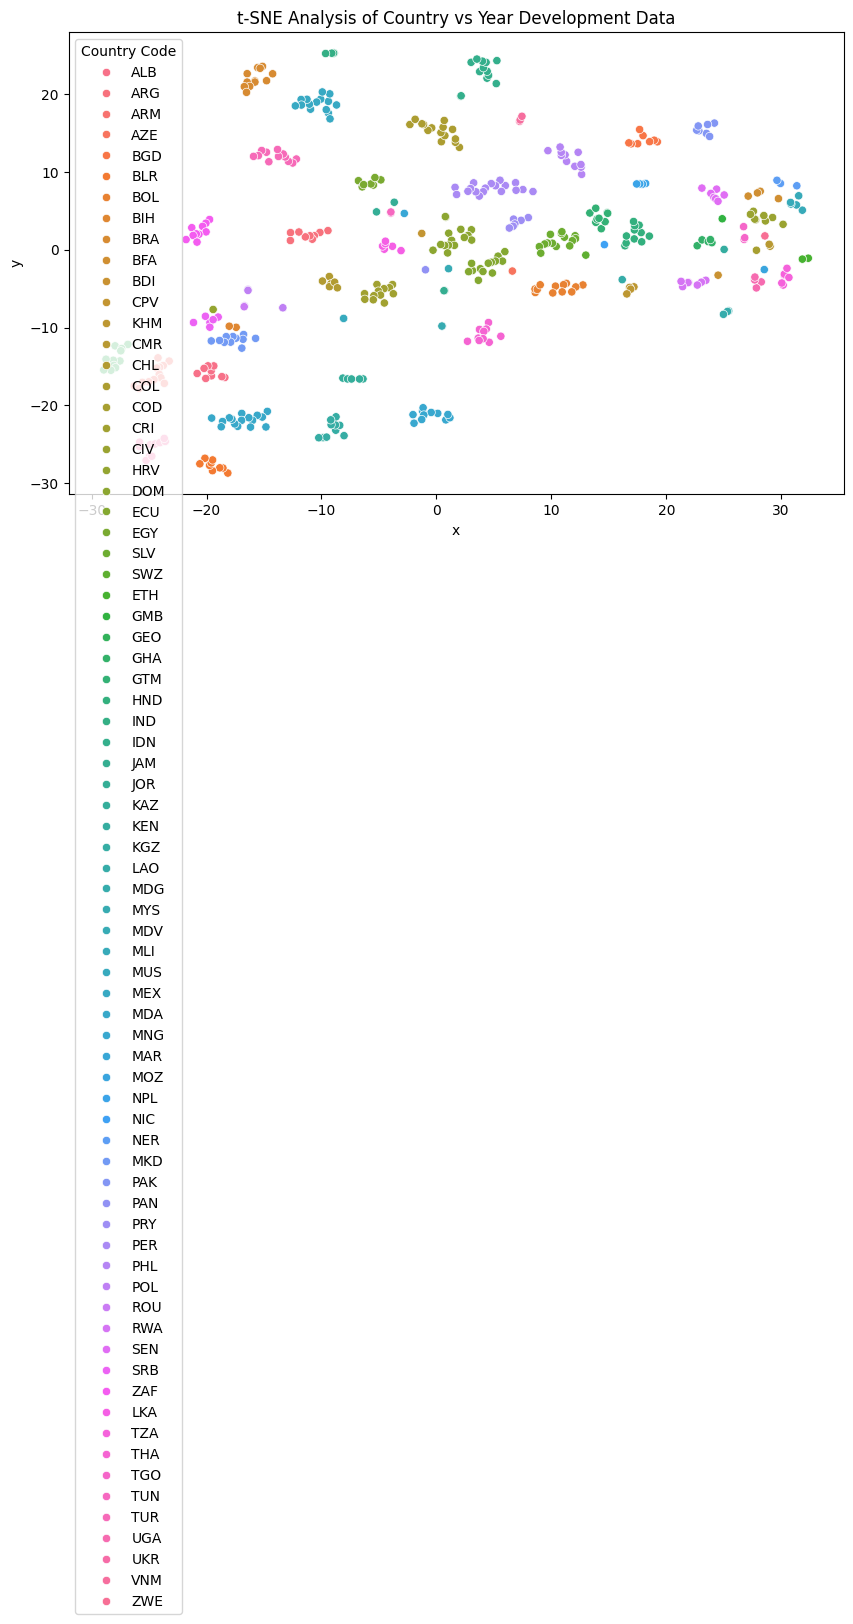

In [20]:
# Reshaping so that there are (Country-year) rows:
df_long = df.melt(
    id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
    var_name = 'Year', 
    value_name = 'Value'
)

df_wide = df_long.pivot_table(
    index = ['Country Name', 'Country Code', 'Year'],
    columns = 'Indicator Code', 
    values = 'Value'
).reset_index()

# Testing different thresholds: 
print("Row completeness per threshold:")
thresholds = [0.5, 0.6, 0.7, 0.8]
for t in thresholds:
    mask = df_wide.drop(['Country Name', 'Country Code', 'Year'], axis=1).notna().mean(axis=1) >= t
    remaining = len(df_wide[mask])
    print(f"   Threshold {t*100:.0f}% -> {remaining} rows kept ({(remaining/len(df_wide))*100:.1f}%)")
    
# Data Collection for Analysis & Justification:
og_shape = df_wide.shape
print("Original shape of pivoted dataset: " + str(og_shape))
print("Original # of country-year observations: " + str(og_shape[0]))
print("Original # of features (x): " + str(og_shape[1] - 3) + "\n")

# Cleaning the missing data, only using 70% complete rows:
numeric_pt = df_wide.drop(['Country Name', 'Country Code', 'Year'], axis=1).notna().mean(axis=1) >= 0.7
df_wide = df_wide[numeric_pt]

features = df_wide.drop(['Country Name', 'Country Code', 'Year'], axis=1)
features = features.fillna(features.mean())

# first I must drop entirely empty rows 
features = features.dropna(axis=1, how='all')
print("Data shape after dropping completely empty columns: " + str(features.shape))

# Conducting t-SNE dimensionality reduction on our dataframe:
# resources used: https://youtu.be/85XaciPBCkw

# Scaling features:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

m = TSNE(n_components=2, learning_rate = 50)
tsne_features = m.fit_transform(features_scaled)

df_wide['x'] = tsne_features[:,0]
df_wide['y'] = tsne_features[:,1]

# Ordering countries by value instead of numerically:
#country_order = df_wide.groupby('Indicator Code')['x'].mean().sort_values().index

plt.figure(figsize=(10,6))
sns.scatterplot(x='x', y ='y', hue='Country Code', data = df_wide)
plt.title("t-SNE Analysis of Country vs Year Development Data")
plt.show()

## Part 2: K-means clustering; Initialization

Selecting k initial centroids randomly from the dataset, where k is the number of clusters you want to find. We want to only use numpy data structures for our K-means clustering implementation.

In [3]:
# Using the K-means clustering tutorial memo as a guideline: 
# Setup: 

def initialise_centroids(X, k):
    # Choose k unique random indices
    indices = random.sample(range(len(X)), k)
    return [X[i] for i in indices]
    
def compute_cluster_mean(cluster_list):
    #For null values
    if len(cluster_list) == 0:
        return None 
    return np.mean(cluster_list, axis=0)

def compute_euclidean_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

def form_new_clusters(X, centroids):
    clusters = [[] for _ in centroids]
    for x in X:
        centroid_distances = [compute_euclidean_distance(x, c) for c in centroids]
        new_cluster = np.argmin(centroid_distances)
        clusters[new_cluster].append(x)
    return clusters

def compute_new_centroids(cluster_list):
    centroids = []
    for cluster_data in cluster_list:
        new_centroid = compute_cluster_mean(cluster_data)
        centroids.append(new_centroid)
    return centroids

def repeat_until_convergence(X, cluster_list, centroids):
    centroid_diff = 10000
    count = 0 #keeping track of the number of iterations
    while centroid_diff > 0:
        new_cluster_list = form_new_clusters(X, centroids)
        new_centroids = compute_new_centroids(new_cluster_list)
        centroid_diff = max([compute_euclidean_distance(centroids[i], new_centroids[i]) for i in range(len(centroids))])
        centroids = new_centroids
        cluster_list = new_cluster_list
        print(centroid_diff)
        count += 1
    return cluster_list, centroids, count

After this setup we now want to implement and compare multiple initialization strategies to understand the effects that differing initializaton will have on the end clustering result. We want to implement both random initialization, using multiple different random seeds and running his test multiple times, as well as K-means ++ initialization, selecting initial centres that are very far apart.


--- Seed 1 ---
37.81006404523605
10.942066060812326
4.983971652934839
2.3487933980861104
4.015966987718303
5.801499793084254
11.984153685149678
12.404353545700532
10.517982479963202
2.9160175699108533
0.0

It took 11 iterations for the algorithm to converge with random initialization.
With final loss: 22241.87

--- Plot ---


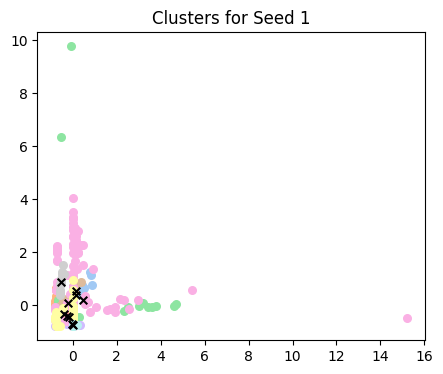


--- Seed 2 ---
30.607542637827624
8.409341447005758
19.07204274917192
5.350987472209934
6.1181924912844625
5.066200012057751
8.138117611138478
15.938047022441197
2.9160175699108533
0.662515267528377
0.0

It took 11 iterations for the algorithm to converge with random initialization.
With final loss: 20799.41

--- Plot ---


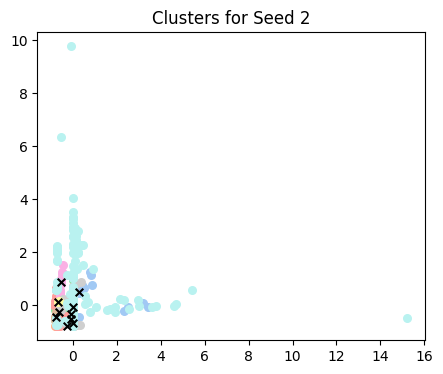


--- Seed 3 ---
40.885978428167
14.580505104571632
5.0131947276669315
4.88721709904035
8.449806436006831
1.504916497308088
1.5244531900748464
1.7002496437602053
2.2211198283492677
1.8737640438339602
2.4812010376390297
0.9155721143396652
1.0492062247223861
1.4248042376345331
0.5215308572172803
0.0

It took 16 iterations for the algorithm to converge with random initialization.
With final loss: 20332.87

--- Plot ---


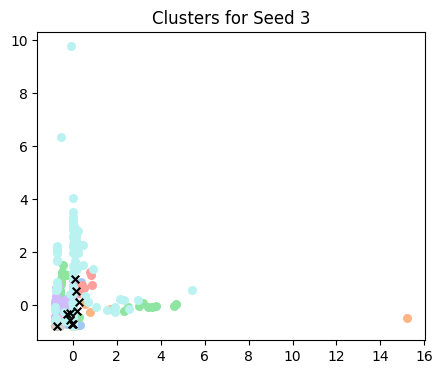


--- Seed 4 ---
35.03527910398298
18.972918278538582
12.661693852303422
13.273066895831978
2.070111636670516
1.0183566414754954
1.0515741046677811
0.9801719032306534
1.4266142643337587
1.1883324517353855
0.7615681249435604
0.5844795787134335
0.837495354094343
0.5374603359390195
0.32079633431904003
0.0

It took 16 iterations for the algorithm to converge with random initialization.
With final loss: 20335.05

--- Plot ---


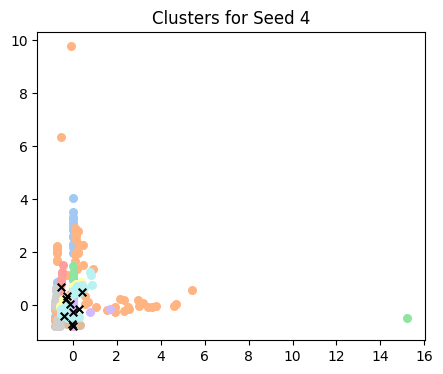


--- Seed 5 ---
36.54766920780455
12.510473015689813
9.57723979999664
0.46441584949490594
0.0

It took 5 iterations for the algorithm to converge with random initialization.
With final loss: 20606.39

--- Plot ---


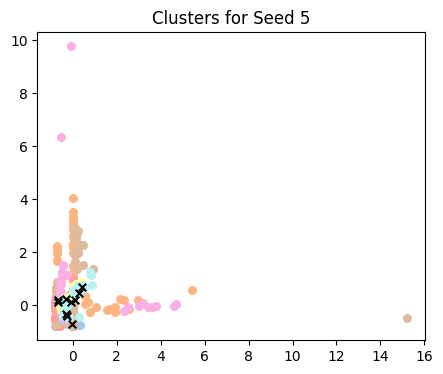

In [4]:
# Random Initialization:

X = features_scaled
k = 10 

# For different seeds:
random_results = []

for seed in [1, 2, 3, 4, 5]:
    np.random.seed(seed)
    random.seed(seed)
    print(f"\n--- Seed {seed} ---")
    centroids = initialise_centroids(X, k)
    cluster_list = form_new_clusters(X, centroids)
    final_clusters, final_centroids, iterations = repeat_until_convergence(X, cluster_list, centroids)

    #loss function
    loss = 0
    for j in range(len(final_clusters)):
        for point in final_clusters[j]:
            loss += compute_euclidean_distance(point, final_centroids[j]**2)
    loss = round(loss, 2)

    print()
    if iterations > 1 and iterations != 0: 
        print("It took " + str(iterations) + " iterations for the algorithm to converge with random initialization.")
        print(f"With final loss: {loss}")
    else: 
        print("It took " + str(iterations) + " iteration for the algorithm to converge with random initialization.")
        print(f"With final loss: {loss}")

    random_results.append({'seed': seed, 'iterations': iterations, 'loss': loss})

    print("\n--- Plot ---")
    colors = sns.color_palette("pastel", k)
    plt.figure(figsize=(5,4))
    for j, cluster in enumerate(final_clusters):
        cluster = np.array(cluster)
        plt.scatter(cluster[:, 0], cluster[:,1], s=30, color=colors[j], label=f"Cluster {j}")
    final_centroids = np.array(final_centroids)
    plt.scatter(final_centroids[:, 0], final_centroids[:, 1], c="black", s=30, marker="x", label="Centroids")
    plt.title(f"Clusters for Seed {seed}")
    plt.show()


--- Seed 1 ---
48.00497711422638
14.132377423333818
8.855155406144885
7.475020223252444
0.8265648484777801
0.0

It took 6 iterations for the algorithm to converge with k-means++.
With final loss: 23836.06

--- Plot ---


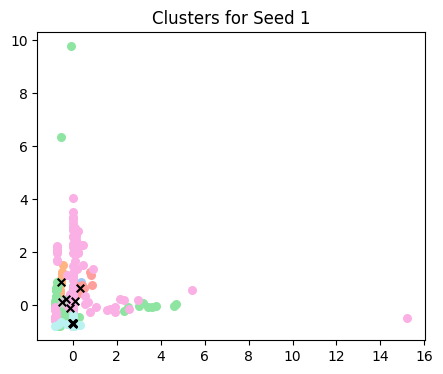


--- Seed 2 ---
31.919246287830163
10.514029635415616
12.25914826680471
7.039327275543369
4.8217566636194285
3.0077886156692304
3.833978008706215
0.5198517111499814
0.0

It took 9 iterations for the algorithm to converge with k-means++.
With final loss: 21950.36

--- Plot ---


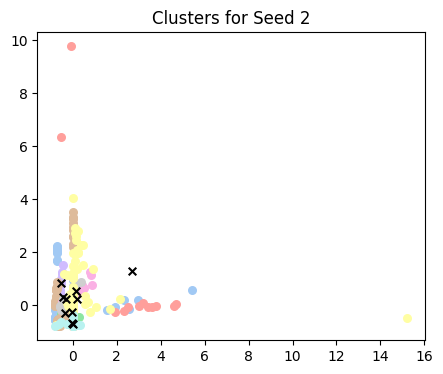


--- Seed 3 ---
35.52585004859378
20.503837516868494
18.482263271923973
37.01691661581763
8.472799375258356
6.372777931784498
19.10061504017041
3.3818456212903847
0.46441584949490594
0.0

It took 10 iterations for the algorithm to converge with k-means++.
With final loss: 24783.14

--- Plot ---


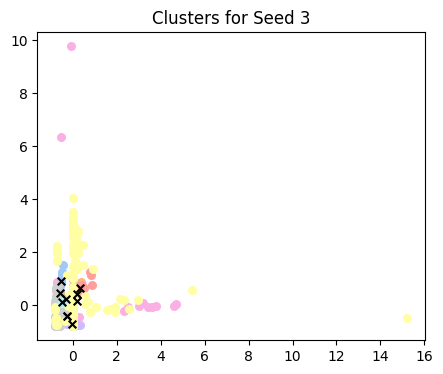


--- Seed 4 ---
34.433641304872395
8.898838275964001
8.416524640825516
3.656772337011412
1.9126978289610885
0.0

It took 6 iterations for the algorithm to converge with k-means++.
With final loss: 20258.49

--- Plot ---


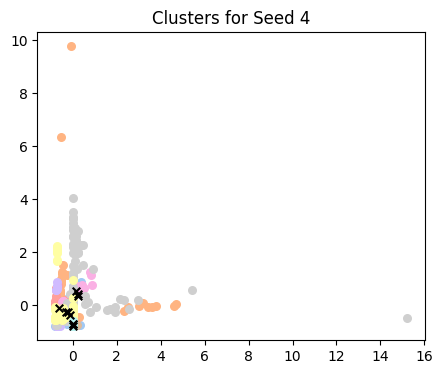


--- Seed 5 ---
32.32290618879702
9.199380312191744
5.713883793178632
5.612610708902697
8.464531051027492
2.8246547053112736
3.6774902844795854
1.8918266173551594
0.6195123388755648
0.5449583301339136
1.3044743224932882
0.6107516353758062
0.0

It took 13 iterations for the algorithm to converge with k-means++.
With final loss: 19991.13

--- Plot ---


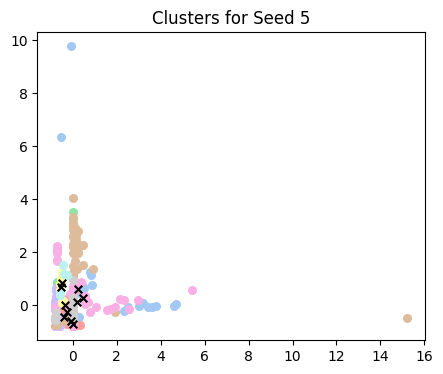

In [21]:
### Initialization via K-means++

def k_means_plus_plus(X,k):
    n_samples = X.shape[0]
    centroids = []
    c_one = np.random.randint(0, n_samples) 
    centroids.append(X[c_one])

    for i in range(1,k):  
        distances = np.array([min(np.linalg.norm(x-c)**2 for c in centroids) for x in X])
        probs = distances/distances.sum()
        c_new = np.random.choice(n_samples, p = probs) 
        centroids.append(X[c_new])
        
    return centroids

# Running our K-means++
kpp_results = []

for seed in [1, 2, 3, 4, 5]:
    np.random.seed(seed)
    random.seed(seed)
    print(f"\n--- Seed {seed} ---")
    centroids = k_means_plus_plus(X, k)
    cluster_list = form_new_clusters(X, centroids)
    final_clusters, final_centroids, iterations = repeat_until_convergence(X, cluster_list, centroids)
    
    #loss function
    loss = 0
    for j in range(len(final_clusters)):
        for point in final_clusters[j]:
            loss += compute_euclidean_distance(point, final_centroids[j]**2)
    loss = round(loss, 2)
                 
    print()
    if iterations > 1: 
        print("It took " + str(iterations) + " iterations for the algorithm to converge with k-means++.")
        print(f"With final loss: {loss}")
    else: 
        print("It took " + str(iterations) + " iteration for the algorithm to converge with random k_means++.")
        print(f"With final loss: {loss}")

    kpp_results.append({'seed': seed, 'iterations': iterations, 'loss': loss})

    print("\n--- Plot ---")
    colors = sns.color_palette("pastel", k)
    plt.figure(figsize=(5,4))
    for j, cluster in enumerate(final_clusters):
        cluster = np.array(cluster)
        plt.scatter(cluster[:, 0], cluster[:,1], s=30, color=colors[j], label=f"Cluster {j}")
    final_centroids = np.array(final_centroids)
    plt.scatter(final_centroids[:, 0], final_centroids[:, 1], c="black", s=30, marker="x", label="Centroids")
    plt.title(f"Clusters for Seed {seed}")
    plt.show()
    

### Cluster Analysis: 
Visualizing the cluster centroids for each cluster in both the random and k-means++ initialization cases. From the similar spread of the centroids across different tests, we can see that there is a stability of cluster assignments across runs.

SUMMARY COMPARISON
Random Initialization:
  Avg. Iterations: 11.8, Avg. Loss: 20863.12 (±711.47)
K-means++ Initialization:
  Avg. Iterations: 8.8, Avg. Loss: 22163.84 (±1900.19)


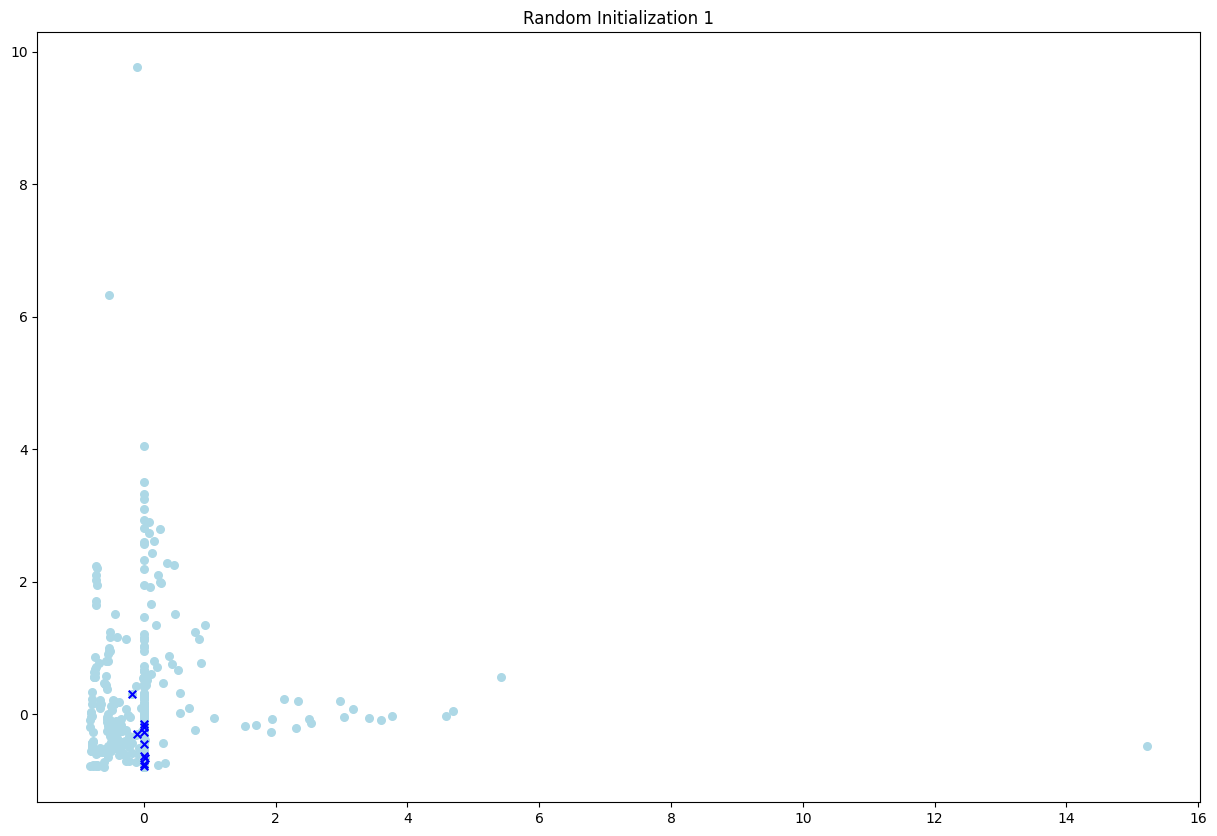

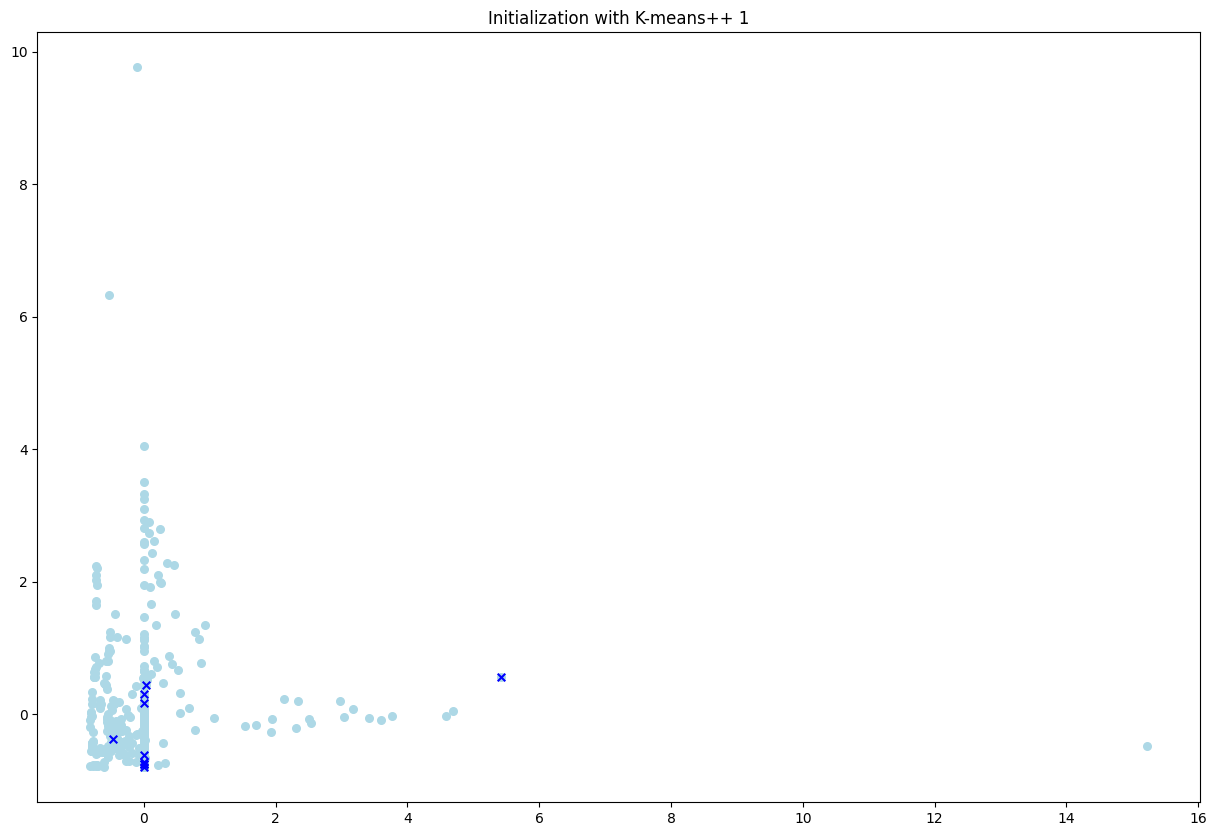

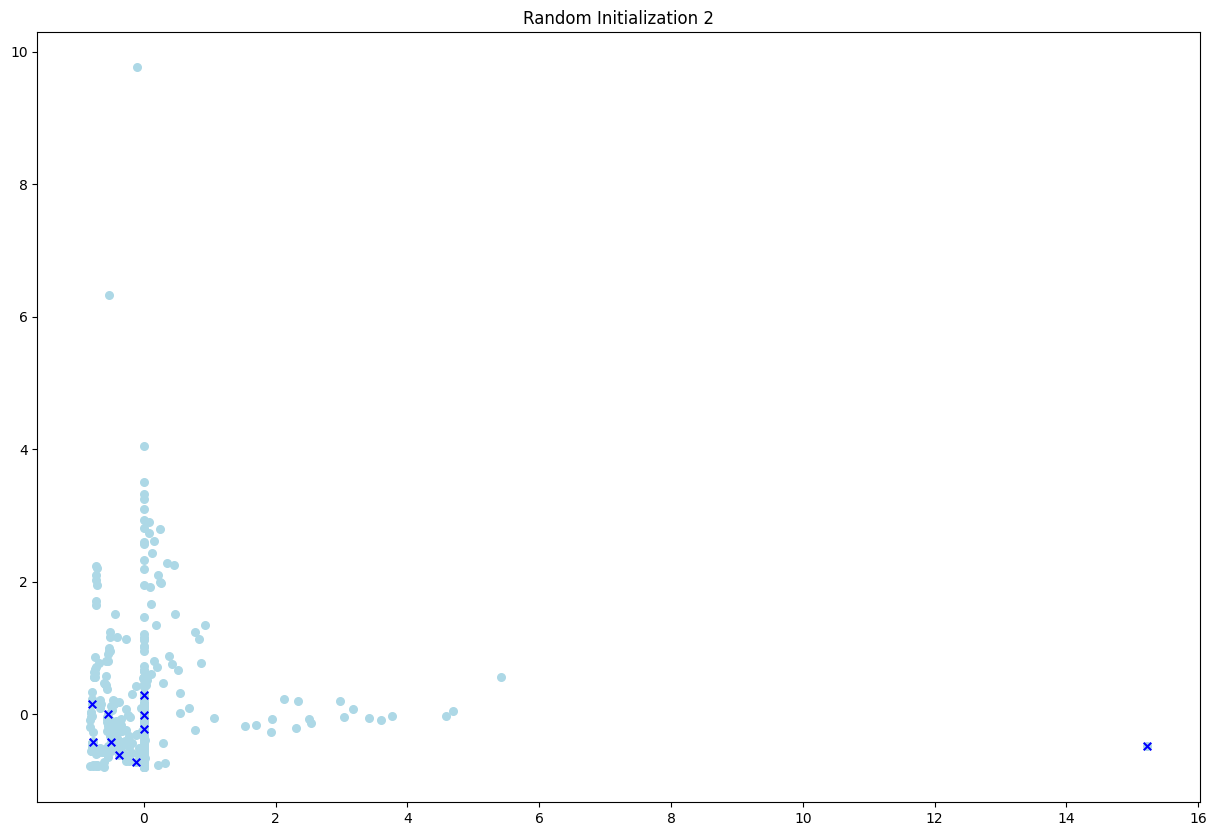

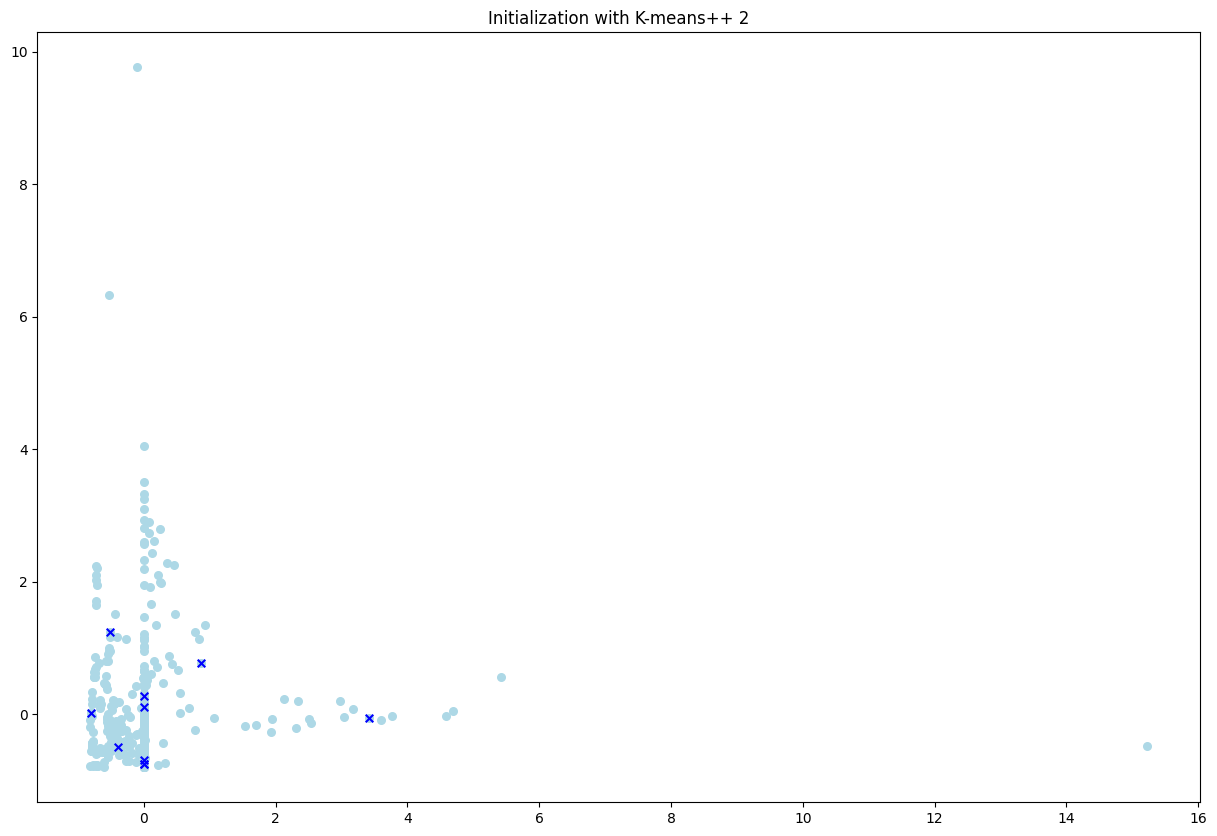

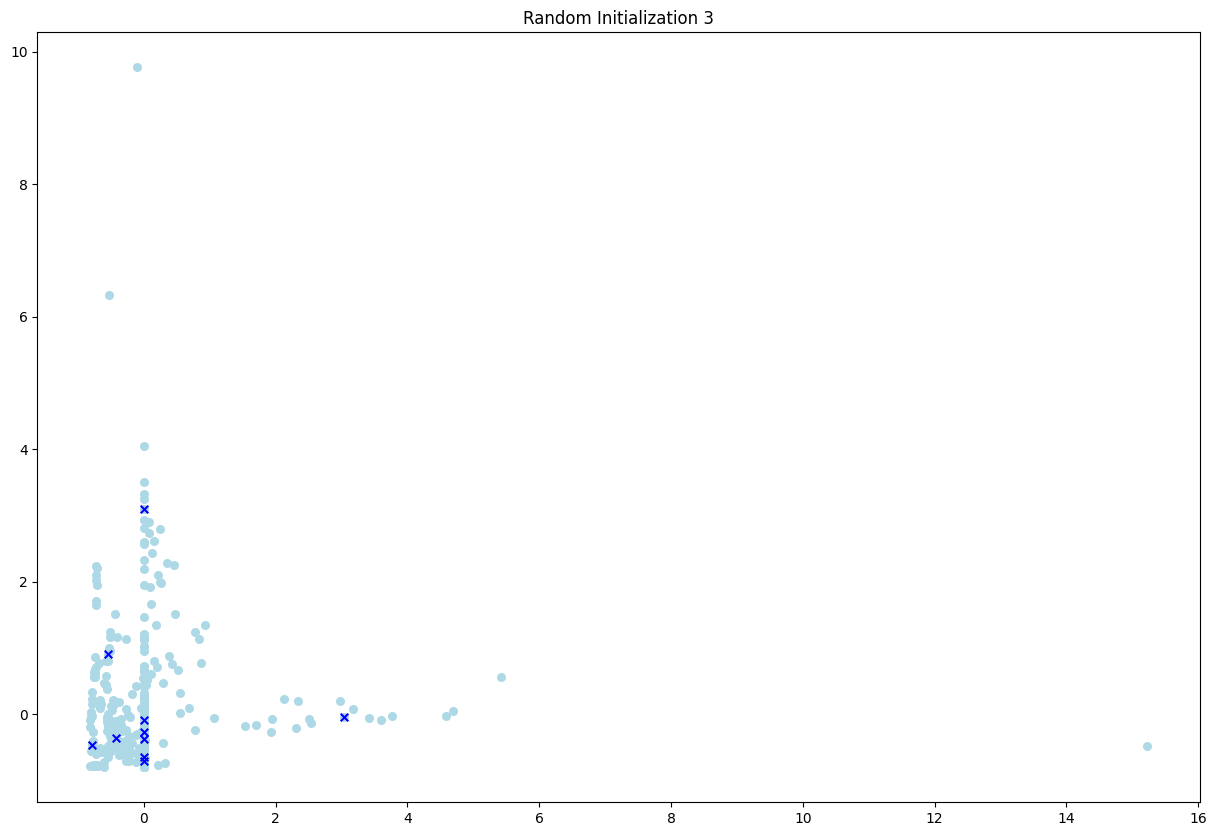

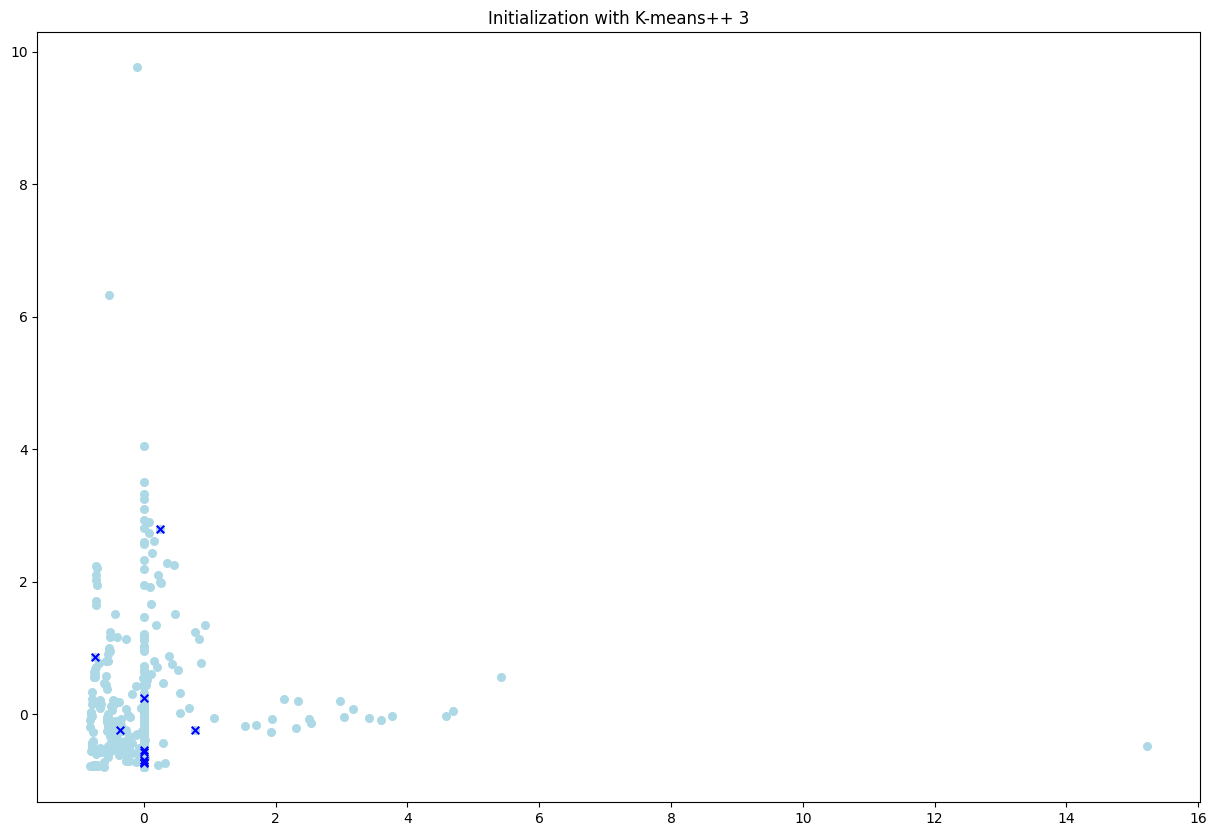

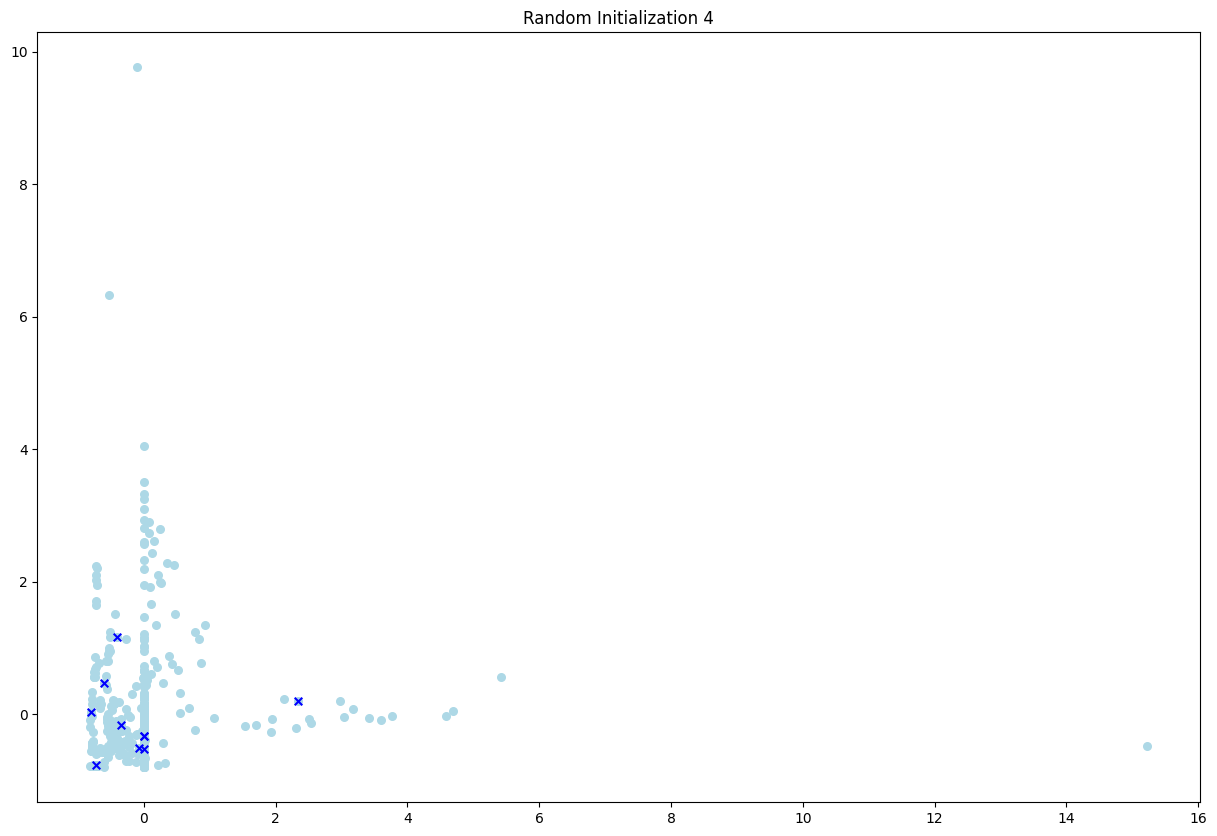

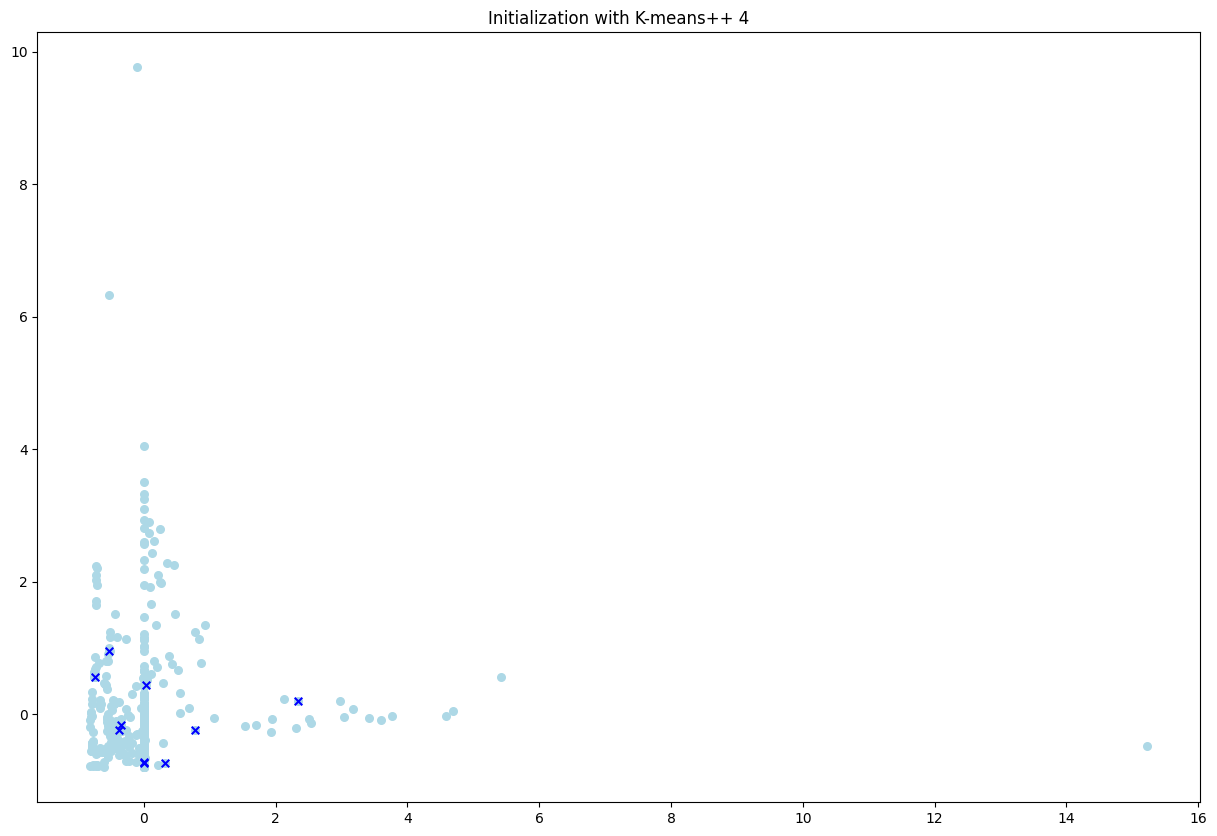

In [6]:
# Visualizing the final centroids & Summary
print("SUMMARY COMPARISON")
print("="*50)

avg_random_iter = np.mean([r['iterations'] for r in random_results])
avg_random_loss = np.mean([r['loss'] for r in random_results])
std_random_loss = np.std([r['loss'] for r in random_results])

avg_kpp_iter = np.mean([r['iterations'] for r in kpp_results])
avg_kpp_loss = np.mean([r['loss'] for r in kpp_results])
std_kpp_loss = np.std([r['loss'] for r in kpp_results])

print(f"Random Initialization:")
print(f"  Avg. Iterations: {avg_random_iter:.1f}, Avg. Loss: {avg_random_loss:.2f} (±{std_random_loss:.2f})")
print(f"K-means++ Initialization:")
print(f"  Avg. Iterations: {avg_kpp_iter:.1f}, Avg. Loss: {avg_kpp_loss:.2f} (±{std_kpp_loss:.2f})")

def plot_initial(X, centroids, title):
    centroids = np.array(centroids)
    plt.figure(figsize=(15,10))
    plt.scatter(X[:, 0], X[:,1], s=30, c="lightblue", label="Data")
    plt.scatter(centroids[:, 0], centroids[:, 1], c="blue", s=30, marker="x", label="Centroids")
    plt.title(title)
    plt.show()

seeds = [69, 420, 777, 1234]
for i, seed in enumerate(seeds, 1):
    print("="*120)
    np.random.seed(seed)
    random.seed(seed)
    c_random = initialise_centroids(X, k)
    c_kmeans = k_means_plus_plus(X, k) 
    plot_initial(X, c_random, f"Random Initialization {i}")
    plot_initial(X, c_kmeans, f"Initialization with K-means++ {i}")

## Part 3: Convergence Criteria

Implementing and evaluating multiple different convergence criteria, including: the maximum iterations, the centroid change threshold, and the inertia change threshold.

Importantly, we want to analyze how each of the above criteria affects the trade-off between computational cost and the solution's quality.

In [7]:
# k-means irrespective of stopping criteria

def kmeans(X, k, c_initial, max_it, c_change_min, inertia_change_min, stop = "max_it"): 
    centroids = c_initial.copy()
    inertia_history = []
    shift_history = []
    count = 0
    
    for it in range(max_it): 
        cluster_list = form_new_clusters(X, centroids) 
        c_new = compute_new_centroids(cluster_list)

        #Handling empty clusters: 
        for i, centroid in enumerate(c_new):
            if centroid is None: 
                c_new[i] = centroids[i]
        
        shift = max([compute_euclidean_distance(centroids[i], c_new[i]) for i in range(len(centroids))])
        shift_history.append(shift) 
    
        inertia = 0
        for i, cluster in enumerate(cluster_list):
            if cluster:  # Check if cluster is not empty
                for point in cluster:
                    inertia += compute_euclidean_distance(point, c_new[i])
        inertia_history.append(inertia) 

        # Stop conditions initial
        stop_early = False
        if stop == 'centroid' and shift < c_change_min:
            break
        elif stop == 'inertia' and it > 0 and abs(inertia_history[-2] - inertia_history[-1]) < inertia_change_min:
            break
        elif stop == 'max_it' and it == max_it - 1:
            break

        centroids = c_new
        count +=1

        if stop_early: 
            break
            
    return cluster_list, centroids, count, inertia_history, shift_history

Convergence Criteria
Criteria        Iterations   Final Inertia   Final Shift 
---------------------------------------------------------
max_it          99           14047.58        0.000000    
centroid        11           14047.58        0.000000    
inertia         8            14050.33        0.274901    


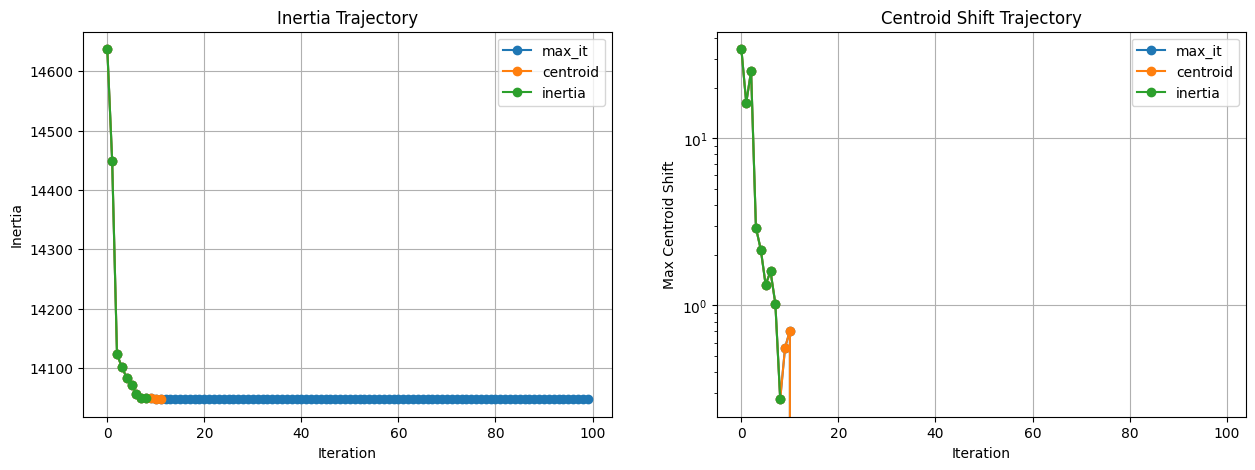

In [8]:
# Maximum Iterations, Centroid Change, and Inertia Change Checks: 
np.random.seed(1)
c_initial = initialise_centroids(X,k)
results = {}

for mode in ["max_it", "centroid", "inertia"]: 
    results[mode] = kmeans(X, k, c_initial, max_it = 100, c_change_min = 0.001, inertia_change_min =1.0, stop = mode)

# Summary for later analysis: 
print("Convergence Criteria")
print("="*50)
header = f"{'Criteria':<15} {'Iterations':<12} {'Final Inertia':<15} {'Final Shift':<12}"
print(header)
print("-" * len(header))
for mode, (_, _, iters, inertia_hist, shift_hist) in results.items():
    print(f"{mode:<15} {iters:<12} {inertia_hist[-1]:<15.2f} {shift_hist[-1]:<12.6f}")

# Plotting comparisons:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

# Inertia
for mode, (_, _, _, inertia_history, _) in results.items():
    axs[0].plot(range(len(inertia_history)), inertia_history, "o-", label=mode)
axs[0].set_title("Inertia Trajectory")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Inertia")
axs[0].legend()
axs[0].grid(True)

# Centroid shift
for mode, (_, _, _, _, shift_history) in results.items():
    axs[1].plot(range(len(shift_history)), shift_history, 'o-', label=mode)
axs[1].set_title("Centroid Shift Trajectory")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Max Centroid Shift")
axs[1].legend()
axs[1].grid(True)
axs[1].set_yscale('log') 

plt.show()

## Part 4: Determining the Optimal K

For K-means clustering, the optimal number of clusters is a fundamental challenge. Instinctively, we'd want to pick k such that the loss function is minimized; however, we don't want to fall victim to overfitting. To combat this, we tend to use a hybrid approach of both manual and automated inspection of the loss function graph. In this situation we will be using the elbow method and the Silhoueete score method.

resource: https://youtu.be/Qh7VxLsaU9M

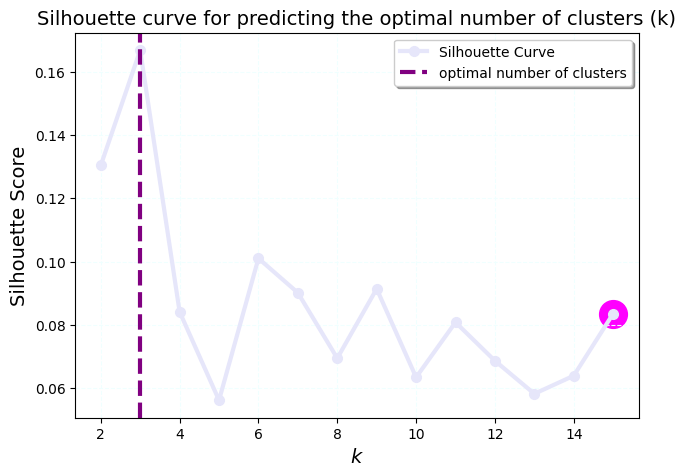

In [9]:
# Comparing cluster quality with Silhouette scores
K_range = range (2, 16)
inertias = []
silhouette_scores = []

for k in K_range: 
    c_initial = initialise_centroids(X, k)
    clusters, centroids, count, inertia_history, shift_history = kmeans(X, k, c_initial, max_it=300, 
                                                                        c_change_min=0.0001, inertia_change_min =0.1, stop = 'centroid')
    inertias.append(inertia_history[-1])
    
    #giving each data point a label
    labels = np.zeros(len(X), dtype=int) 
    for cluster_idx, cluster_points in enumerate(clusters): 
        for p in cluster_points: 
            point_idx = np.where((X==p).all(axis=1))[0]
            labels[point_idx] = cluster_idx

    silhouettes = silhouette_score(X, labels) if k > 1 else None
    silhouette_scores.append(silhouettes)

k_optimal_index = np.argmax(silhouette_scores)
k_optimal = K_range[k_optimal_index]

# Plotting the Silhouette Scores Graph
rcParams['figure.figsize'] = 16, 5
plt.subplot(1, 2, 1)
plt.plot(K_range, silhouette_scores, "o-", color = "lavender", 
            linewidth=3, markersize =7, label = "Silhouette Curve")
plt.xlabel("$k$", fontsize=14) 
plt.ylabel("Silhouette Score", fontsize=14)
plt.grid(which="major", color="azure", linestyle="--") 
plt.title("Silhouette curve for predicting the optimal number of clusters (k)", fontsize=14) 

plt.axvline(x=k_optimal, linestyle= "--", color = "purple", linewidth=3, 
             label="optimal number of clusters")
plt.scatter(k, silhouette_scores[k-2], c="magenta", s=400)
plt.legend(shadow=True)
plt.tight_layout
plt.show()

Inertia Percentage Change per k:
k = 2: 0.00% decrease
k = 3: 3.47% decrease
k = 4: 1.77% decrease
k = 5: 2.79% decrease
k = 6: 0.90% decrease
k = 7: 0.54% decrease
k = 8: 2.05% decrease
k = 9: 0.31% decrease
k = 10: 1.52% decrease
k = 11: 0.88% decrease
k = 12: 2.81% decrease
k = 13: -1.86% decrease
k = 14: -1.31% decrease
k = 15: 5.08% decrease

The optimal number of clusters based on the elbow method (>1.0% change threshold) is k = 3
The optimal number of clusters based on the silhouette score is k = 3


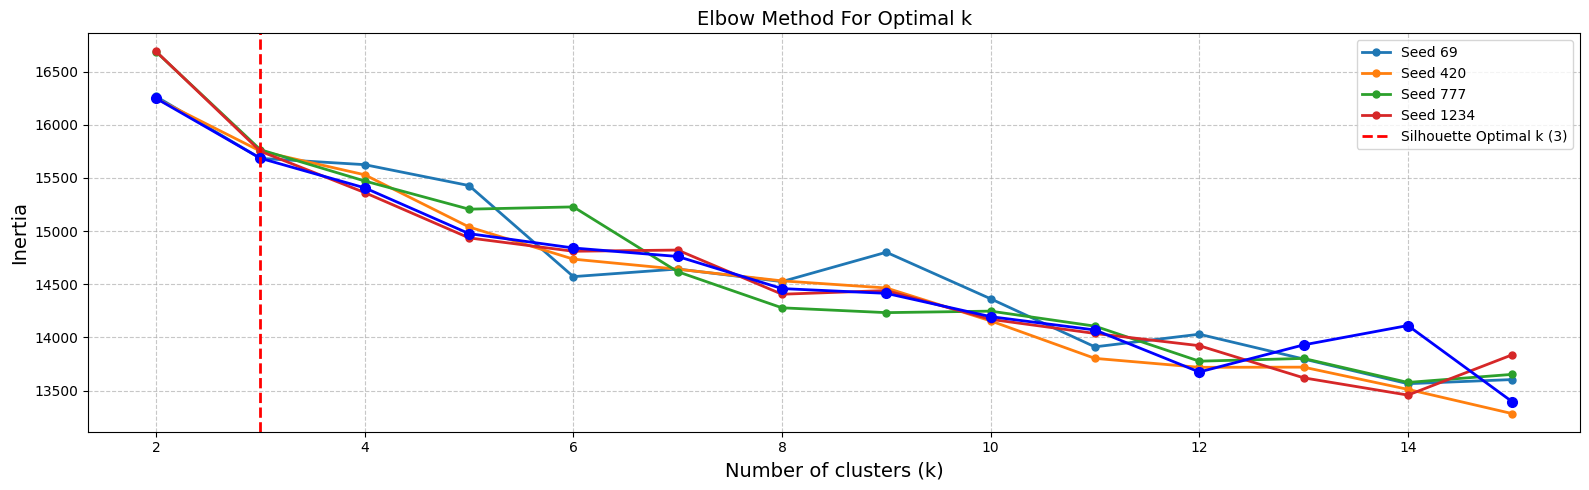

In [22]:
# Automating the elbow method: 

inertia_perc_change = [0]
for i in range(1, len(inertias)):
    change = (inertias[i-1] - inertias[i]) / inertias[i-1] * 100  # % decrease
    inertia_perc_change.append(change)
    
threshold = 1.0
k_elbow = None

for k_idx, change in enumerate(inertia_perc_change):
    if change < threshold:
        k_elbow = K_range[k_idx]
        break
if k_elbow is None:
    k_elbow = K_range[-1]

print("Inertia Percentage Change per k:")
for k, change in zip(K_range, inertia_perc_change):
    print(f"k = {k}: {change:.2f}% decrease")

print(f"\nThe optimal number of clusters based on the elbow method (>{threshold}% change threshold) is k = {k_elbow + 1}")
print(f"The optimal number of clusters based on the silhouette score is k = {k_optimal}")


# Plotting the elbow method graphs for manual inspection with previous "seeds"
fig, (ax1) = plt.subplots(1, figsize=(16, 5))

for seed in seeds:
    np.random.seed(seed)
    random.seed(seed)
    inertias_for_this_seed = []
    for k in K_range: 
        c_initial = initialise_centroids(X, k)
        clusters, centroids, count, inertia_history, shift_history = kmeans(X, k, c_initial, max_it=300, 
                                                                            c_change_min=0.0001, inertia_change_min=0.1, stop='centroid')
        inertias_for_this_seed.append(inertia_history[-1])
    plt.plot(K_range, inertias_for_this_seed, 'o-', linewidth=2, markersize=5, label=f'Seed {seed}')

# Regular plot setup 
ax1.plot(K_range, inertias, "bo-", linewidth=2, markersize=7)
ax1.set_xlabel("Number of clusters (k)", fontsize=14)
ax1.set_ylabel("Inertia", fontsize=14)
ax1.set_title("Elbow Method For Optimal k", fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)

ax1.axvline(x=k_optimal, linestyle="--", color="red", linewidth=2, label=f'Silhouette Optimal k ({k_optimal})')
ax1.legend()

plt.tight_layout()
plt.show()

## Part 5: Dimensionality reduction with PCA

We want to apply PCA dimensionality reduction to our preprocessed data so that we can visualize our cluster in both a 2D and 3D PCA space so that, alongside our K-means clustering and t-SNE tests, we can better interpret the spread of the data and identify which original features most strongly contribute to each component.

In [11]:
# Applying PCA to our dataset

components_list = [1, 2, 3, 4, 5, 10, 20, 50, 100]
pca_results = {}

for c in components_list: 
    pca = PCA(n_components=c)
    X_pca = pca.fit_transform(X)
    pca_results[c] = { "X_pca":X_pca,
                       "explained_var": pca.explained_variance_ratio_,
                       "components":pca.components_}
    print(f"PCA with {c} components explains {np.sum(pca.explained_variance_ratio_)*100:.1f}% of the variance in the dataset")

# Top 3 principal components

x_names = [f"Feature {i}" for i in range(X.shape[1])]

for n, info in pca_results.items():
    print("\nTop 3 components for a " + str(n) + "D PCA:")
    for i in range(min(3, n)):
        comp = info["components"][i]
        top_features = np.argsort(np.abs(comp))[::-1][:5]
        top_features_names = [x_names[j] for j in top_features]
        top_loadings = comp[top_features]
        print(f"PC{i+1}: {top_features_names}, loadings: {top_loadings}")


PCA with 1 components explains 14.1% of the variance in the dataset
PCA with 2 components explains 25.3% of the variance in the dataset
PCA with 3 components explains 30.0% of the variance in the dataset
PCA with 4 components explains 34.3% of the variance in the dataset
PCA with 5 components explains 37.3% of the variance in the dataset
PCA with 10 components explains 47.6% of the variance in the dataset
PCA with 20 components explains 59.3% of the variance in the dataset
PCA with 50 components explains 76.1% of the variance in the dataset
PCA with 100 components explains 88.0% of the variance in the dataset

Top 3 components for a 1D PCA:
PC1: ['Feature 1310', 'Feature 1237', 'Feature 1256', 'Feature 1272', 'Feature 1308'], loadings: [ 0.06250563  0.06181241  0.06160328 -0.0614449   0.06142409]

Top 3 components for a 2D PCA:
PC1: ['Feature 1310', 'Feature 1237', 'Feature 1256', 'Feature 1272', 'Feature 1308'], loadings: [ 0.06250563  0.06181241  0.06160328 -0.06144491  0.0614241 ]
P

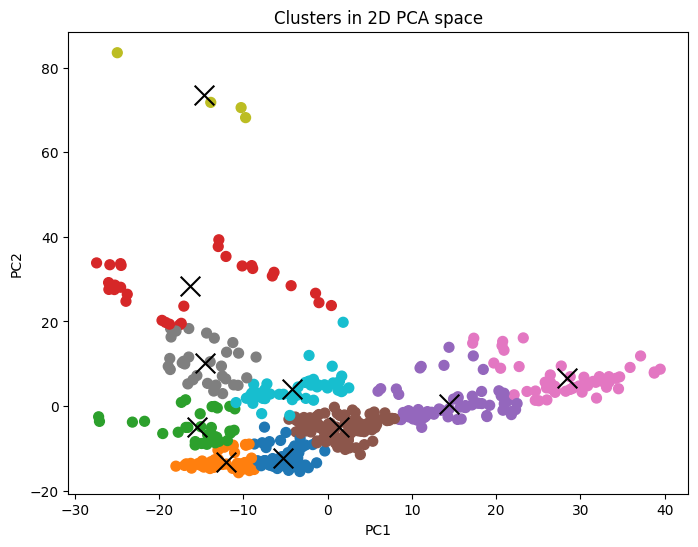

In [12]:
# 2D PCA Visualisation

X_pca_2d = pca_results[2]["X_pca"]
k = 10
c_initial = initialise_centroids(X_pca_2d, k)
clusters_pca, centroids_pca, iterations, inertia_hist, shift_hist = kmeans(
    X_pca_2d, k, c_initial, max_it=300, c_change_min=1e-4, inertia_change_min=1e-4, stop="centroid")

labels = np.zeros(len(X_pca_2d), dtype=int)
for cluster_idx, cluster_points in enumerate(clusters_pca):
    for point in cluster_points:
        idx = np.where((X_pca_2d == point).all(axis=1))[0]
        labels[idx] = cluster_idx

centroids_pca = np.array(centroids_pca)
plt.figure(figsize=(8,6))
plt.scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=labels, cmap="tab10", s=50)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c="black", s=200, marker="x")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters in 2D PCA space")
plt.show()

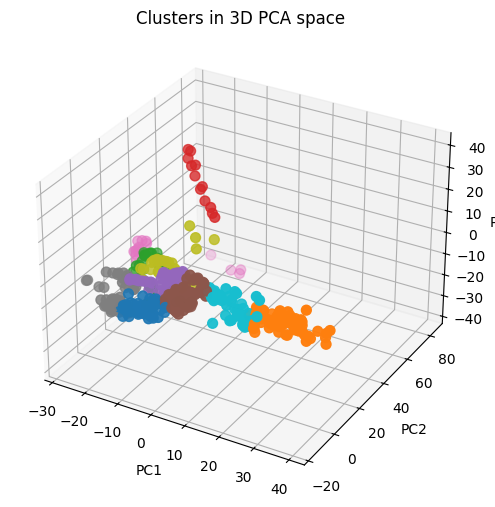

In [13]:
# 3D PCA Visualisation

X_pca_3d = pca_results[3]["X_pca"]
c_initial = initialise_centroids(X_pca_3d, k)
clusters_3d, centroids_3d, iterations, _, _ = kmeans(
    X_pca_3d, k, c_initial, max_it=300, c_change_min=1e-4, inertia_change_min=1e-4, stop="centroid"
)

labels_3d = np.zeros(len(X_pca_3d), dtype=int)
for cluster_idx, cluster_points in enumerate(clusters_3d):
    for point in cluster_points:
        idx = np.where((X_pca_3d == point).all(axis=1))[0]
        labels_3d[idx] = cluster_idx

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2], c=labels_3d, cmap="tab10", s=50)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("Clusters in 3D PCA space")
plt.show()

## 5.1) PCA interpretation: 

What I accidentally did for Cluster interpretation, looking to see what parts of the PCA analysis, what factors go into defining the principal components and what part of the features explain most of the variance of our WDCI data set


PCA Component Interpretation:

PCA with 2 components (Explains 25.3% total variance):
--------------------------------------------------

Principal Component 1 (14.1% variance):
 + Strongly POSITIVE features (high values indicate):
    • Young dependency ratio: 0.063
    • Crude birth Rate: 0.062
    • Male Populations age 0-4: 0.062
    • SP.POP.DPND: 0.061
    • Male population 0-14: 0.061
    • SP.POP.0004.FE.5Y: 0.061
    • SP.POP.0014.TO.ZS: 0.061
 - Strongly NEGATIVE features (low values indicate):
    • Male population 15-64: -0.061
    • Total population 15-64: -0.061
    • Female population 40-44: -0.060
    • Female population 15-64: -0.060
    • Male population 40-44: -0.059
    • SP.POP.4549.FE.5Y: -0.059
    • SH.STA.BASS.ZS: -0.058
 Interpretation: PC1 is primarily related to Demographic

Principal Component 2 (11.2% variance):
 + Strongly POSITIVE features (high values indicate):
    • Urban population total: 0.070
    • Gross National Product: 0.068
    • Gross Domesti

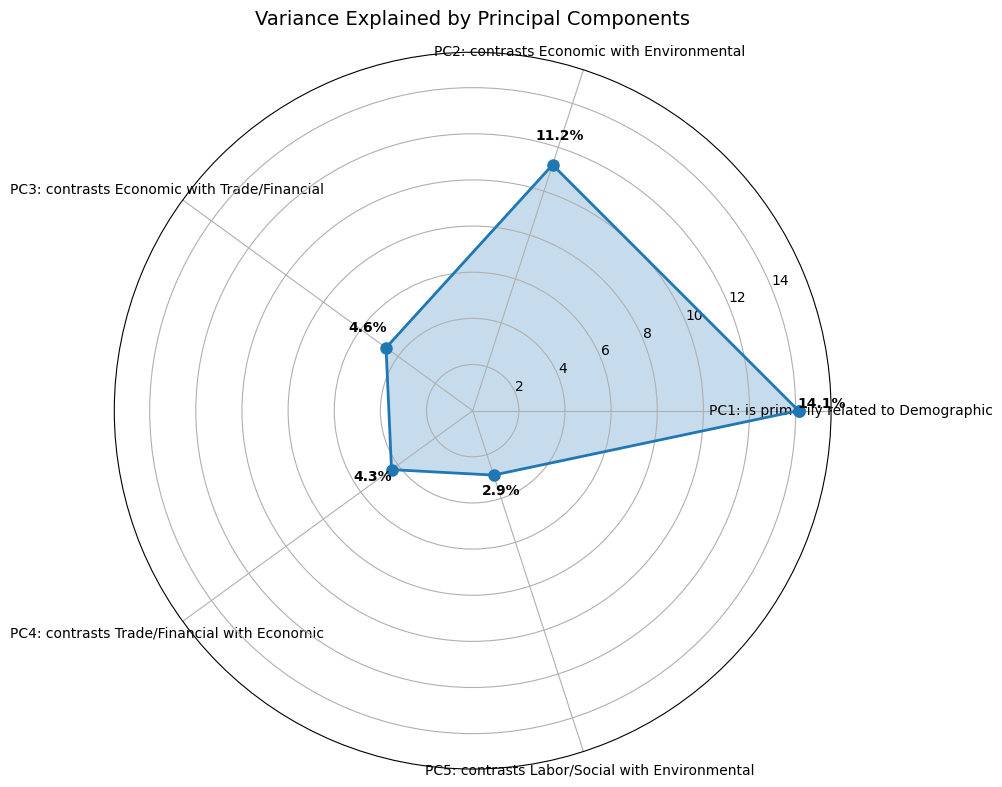

In [14]:
# Parsing the HDI 
hdi_df = pd.read_excel(
    "HDR25_Statistical_Annex_HDI_Table.xlsx",
    skiprows=4,
    header=[0, 1]
)

hdi_df.columns = ['_'.join(filter(lambda x: str(x) != 'nan', map(str, col))).strip() 
                 for col in hdi_df.columns.values]

#print("Flattened columns:")
#print(hdi_df.columns.tolist())
#print("\nFirst few rows:")
#print(hdi_df.head())

# feature descriptions:
feature_descriptions = {
    # Demographic features (PC1)
    'SP.POP.DPND.YG': 'Young dependency ratio',
    'SP.DYN.CBRT.IN': 'Crude birth Rate',
    'SP.POP.0004.MA.5Y': 'Male Populations age 0-4',
    'SP.POP.DPND: 0.061': 'Total dependency ratio',
    'SP.POP.0014.MA.ZS': 'Male population 0-14',
    'SP.POP.1564.MA.ZS': 'Male population 15-64',
    'SP.POP.1564.TO.ZS': 'Total population 15-64',
    'SP.POP.4044.FE.5Y': 'Female population 40-44',
    'SP.POP.1564.FE.ZS': 'Female population 15-64',
    'SP.POP.4044.MA.5Y': 'Male population 40-44',
    
    # Economic features (PC2)
    'SP.URB.TOTL':'Urban population total',
    'NY.GNP.MKTP.PP.CD': 'Gross National Product',
    'NY.GDP.MKTP.PP.CD': 'Gross Domestic Product',
    'NV.AGR.TOTL.CD': 'Agricultural value added',
    'NE.CON.PRVT.PP.CD': 'Household consumption',
    'BN.GSR.FCTY.CD': 'Net income from abroad',
    'EN.GHG.CO2.LU.FL.MT.CE.AR5': 'CO2 emissions from land use change',
    'BN.FIN.TOTL.CD': 'Net financial transactions',
    'EN.GHG.CO2.LU.OL.MT.CE.AR5': 'Other land use CO2 emissions',
    'BN.CAB.XOKA.CD': 'Current account balance',

    # Developmental and Capital features (PC3) 
    'NY.GNP.PCAP.CN': 'GNI per capita',
    'NY.GDP.PCAP.CN': 'GDP per capita',
    'NY.GDP.PCAP.KN': 'GDP per capita',
    'NE.CON.GOVT.KN': 'General government final consumption expenditure',
    'NV.SRV.TOTL.KN': 'Services, value added',
    'MS.MIL.XPND.CN': 'Military expenditure',
    'NE.CON.TOTL.KN': 'Final consumption expenditure',
    'NY.GSR.NFCY.CN': 'Net income from abroad',
    'DC.DAC.JPNL.CD': 'Net ODA received from Japan',
    'SH.STA.SUIC.FE.P5': 'Suicide mortality rate, female',
    'TM.VAL.MRCH.R4.ZS': 'Merchandise trade - Low & middle income',
    'AG.LND.ARBL.ZS': 'Arable land',
    'SE.SEC.DURS': 'Duration of secondary education',
    'IP.PAT.RESD': 'Patent applications by residents',

    # Inequality and Distribution features (PC4)
    'SI.POV.GINI': 'Gini index',
    'SI.DST.05TH.20': 'Income share held by the  lowest fifth',
    'SI.DST.10TH.10': 'Income share held by highest 10%',
    'SI.DST.50MD': 'Median income/consumption',
    'PA.NUS.PPPC.RF': 'Price level ratio',
    'TM.VAL.MRCH.R3.ZS': 'Merchandise trade',
    'TX.VAL.MRCH.R3.ZS': 'Merchandise exports',
    'SI.DST.02ND.20': 'Income share held by second 20%',
    'SI.DST.FRST.20': 'Income share held by lowest 20%',
    'SI.DST.FRST.10': 'Income share held by lowest 10%',
    'SH.DYN.NCOM.MA.ZS': 'Male Mortality from disease',
    'SI.DST.03RD.20': 'Income share held by third 20%',
    'SH.DYN.NCOM.ZS': 'Total Mortality from disease',
    'DC.DAC.NZLL.CD': 'Net ODA from New Zealand',
    
    # Labour and Gender features (PC5)
    'SL.TLF.CACT.FM.ZS': 'Labor force participation rate, total',
    'SL.TLF.ACTI.FE.ZS': 'Labor force, female',
    'SL.TLF.TOTL.FE.ZS': 'Labor force, total',
    'SL.TLF.CACT.FE.ZS': 'Labor force participation rate, female',
    'SL.TLF.CACT.FM.NE.ZS': 'Labor force participation rate, total (15-24)',
    'SL.EMP.TOTL.SP.FE.ZS': 'Employment to population ratio, 15+, female',
    'SL.TLF.CACT.FE.NE.ZS': 'Labor force participation rate, female (15-24)',
    'SL.UEM.NEET.FE.ME.ZS': 'Not in Education, Employment, or Training, female - Middle East',
    'SL.UEM.NEET.FE.ZS': 'Not in Education, Employment, or Training, female',
    'SL.UEM.NEET.ME.ZS': 'Not in Education, Employment, or Training, male - Middle East',
    'EG.GDP.PUSE.KO.PP.KD': 'Energy use - Constant PPP',
    'EG.GDP.PUSE.KO.PP': 'Energy use - Current PPP',
    'SL.UEM.NEET.ZS': 'Not in Education, Employment, or Training, total',
    'ER.H2O.FWST.ZS': 'Freshwater withdrawal'
}
# Finding the names of the principal components
feature_names = features.columns.tolist()
pc_interpretations = [""] * 5 

print("\nPCA Component Interpretation:")
print("=" * 60)

# top 5 principal components
max_components = min(5, len(pca_results))

for n_components in range(2, max_components + 1):
    pca_data = pca_results[n_components]
    total_variance = np.sum(pca_data["explained_var"]) * 100
    
    print(f"\nPCA with {n_components} components (Explains {total_variance:.1f}% total variance):")
    print("-" * 50)
    
    for i in range(n_components):
        component = pca_data["components"][i]
        variance_explained = pca_data["explained_var"][i] * 100
        print(f"\nPrincipal Component {i+1} ({variance_explained:.1f}% variance):")
        top_positive = np.argsort(component)[-7:][::-1]
        top_negative = np.argsort(component)[:7]
        
        # positive features
        print(" + Strongly POSITIVE features (high values indicate):")
        pos_descriptions = [] # Store descriptions for interpretation
        for idx in top_positive:
            feat_name = feature_names[idx]
            feat_desc = feature_descriptions.get(feat_name, feat_name)
            pos_descriptions.append(feat_desc) # Add to list
            print(f"    • {feat_desc}: {component[idx]:.3f}")
        
        # negative features
        print(" - Strongly NEGATIVE features (low values indicate):")
        neg_descriptions = [] # Store descriptions for interpretation
        for idx in top_negative:
            feat_name = feature_names[idx]
            feat_desc = feature_descriptions.get(feat_name, feat_name)
            neg_descriptions.append(feat_desc) # Add to list
            print(f"    • {feat_desc}: {component[idx]:.3f}")
        
        all_descriptions = " ".join(pos_descriptions + neg_descriptions).lower()
        
        #keyword groups
        theme_keywords = {
            'Demographic': ['population', 'birth', 'death', 'age', 'dependency', 'fertility', 'mortality', 'life expectancy'],
            'Economic': ['gdp', 'gni', 'income', 'gross', 'product', 'consumption', 'expenditure', 'value added', 'account'],
            'Labor/Social': ['labor', 'employment', 'unemployment', 'force', 'participation', 'neet', 'gender'],
            'Trade/Financial': ['trade', 'export', 'import', 'investment', 'oda', 'financial', 'current account'],
            'Environmental': ['co2', 'emission', 'energy', 'water', 'withdrawal', 'arable', 'land'],
            'Inequality': ['gini', 'income share', 'inequality', 'poorest', 'richest']
        }
        
        # themes based on keywords
        component_themes = {}
        for theme, keywords in theme_keywords.items():
            count = sum(1 for keyword in keywords if keyword in all_descriptions)
            if count > 0:
                component_themes[theme] = count
                
        sorted_themes = sorted(component_themes.items(), key=lambda x: x[1], reverse=True)
        main_themes = [theme for theme, count in sorted_themes[:2]] # Top 2 themes

        if len(main_themes) == 2:
            interpretation = f"contrasts {main_themes[0]} with {main_themes[1]}"
        elif len(main_themes) == 1:
            interpretation = f"is primarily related to {main_themes[0]}"
        else:
            interpretation = "has mixed themes (interpret carefully)"

        pc_interpretations[i] = interpretation
        print(f" Interpretation: PC{i+1} {interpretation}")

# Radar chart of component contributions
if max_components >= 3:
    components_to_plot = min(5, max_components)
    angles = np.linspace(0, 2 * np.pi, components_to_plot, endpoint=False).tolist()
    angles += angles[:1] 
    
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
    
    # Plot variance explained for each component
    variances = pca_results[components_to_plot]["explained_var"][:components_to_plot] * 100
    variances = np.append(variances, variances[0])
    
    ax.plot(angles, variances, 'o-', linewidth=2, markersize=8)
    ax.fill(angles, variances, alpha=0.25)
    labels = [f'PC{i+1}: {pc_interpretations[i]}' for i in range(components_to_plot)]
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_ylim(0, max(variances) * 1.1)
    ax.set_title('Variance Explained by Principal Components', size=14, pad=20)
    ax.grid(True)

    # Add value labels
    for i, v in enumerate(variances[:-1]):
        ax.text(angles[i], v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## Part 6: Cluster Interpretation


In [15]:
# Cluster Interpretation

print("\n" + "="*80)
print("Cluster Interpretation Analysis")
print("="*80)

# Store results for markdown reporting
cluster_results = []

# 1. Detailed cluster analysis
personas = [
    "Energy-Constrained Developing Economies",
    "Environmentally-Managed Transition Economies",
    "Specialized Niche Economic Systems"
]

for cluster_id in range(len(clusters)):
    print(f"\n Cluster {cluster_id} (Size: {len(clusters[cluster_id])} countries)")
    print("-" * 60)
    
    centroid = centroids[cluster_id]
    top_features = np.argsort(np.abs(centroid))[-5:][::-1]
    
    cluster_info = {
        'id': cluster_id,
        'size': len(clusters[cluster_id]),
        'characteristics': [],
        'pattern': ""
    }
    
    print("Dominant characteristics:")
    for feat_idx in top_features:
        feat_name = feature_names[feat_idx]
        feat_desc = feature_descriptions.get(feat_name, feat_name)
        value = centroid[feat_idx]
        direction = "HIGH" if value > 0 else "LOW"
        
        char_desc = f"{direction} {feat_desc}"
        cluster_info['characteristics'].append(char_desc)
        print(f"   • {char_desc}")
    
    # Determine cluster pattern
    pattern_parts = []
    if any('EG.CFT.ACCS.ZS' in char for char in cluster_info['characteristics']):
        pattern_parts.append("Energy-Access Focused")
    if any('SP.POP.DPND' in char for char in cluster_info['characteristics']):
        pattern_parts.append("Demographic Dynamics")
    if any('NY.ADJ.DPEM.GN.ZS' in char for char in cluster_info['characteristics']):
        pattern_parts.append("Environmental Impact")
    
    cluster_info['pattern'] = " + ".join(pattern_parts) if pattern_parts else "Mixed Development"
    cluster_results.append(cluster_info)

# 2. Print summary
print("\n" + "="*80)
print("CLUSTER SUMMARY")
print("="*80)

for cluster in cluster_results:
    print(f"Cluster {cluster['id']}: {cluster['pattern']} ({cluster['size']} countries)")

# Store for markdown
unique_patterns = len(set(cluster['pattern'] for cluster in cluster_results))
smallest_cluster = min(cluster['size'] for cluster in cluster_results)
largest_cluster = max(cluster['size'] for cluster in cluster_results)

print("\n" + "="*80)
print("CLUSTER PERSONAS")
print("="*80)
for cluster_id, persona in enumerate(personas):
    print(f"Cluster {cluster_id}: {persona}")


Cluster Interpretation Analysis

 Cluster 0 (Size: 10 countries)
------------------------------------------------------------
Dominant characteristics:
   • HIGH SH.DYN.0509
   • HIGH SI.POV.GAPS
   • HIGH SH.MMR.RISK.ZS
   • HIGH SH.DYN.1014
   • HIGH SE.PRM.REPT.FE.ZS

 Cluster 1 (Size: 88 countries)
------------------------------------------------------------
Dominant characteristics:
   • HIGH NV.SRV.EMPL.KD
   • HIGH SH.XPD.GHED.PP.CD
   • HIGH SL.GDP.PCAP.EM.KD
   • HIGH SH.XPD.GHED.PC.CD
   • HIGH NY.ADJ.NNTY.PC.CD

 Cluster 2 (Size: 43 countries)
------------------------------------------------------------
Dominant characteristics:
   • HIGH EN.GHG.CO2.TR.MT.CE.AR5
   • HIGH NE.GDI.TOTL.KD
   • HIGH NV.IND.TOTL.CD
   • HIGH NE.DAB.TOTL.KD
   • HIGH NV.IND.TOTL.KD

 Cluster 3 (Size: 4 countries)
------------------------------------------------------------
Dominant characteristics:
   • HIGH NY.TRF.NCTR.CN
   • HIGH PA.NUS.ATLS
   • HIGH PA.NUS.FCRF
   • HIGH PA.NUS.PPP
   • HIG

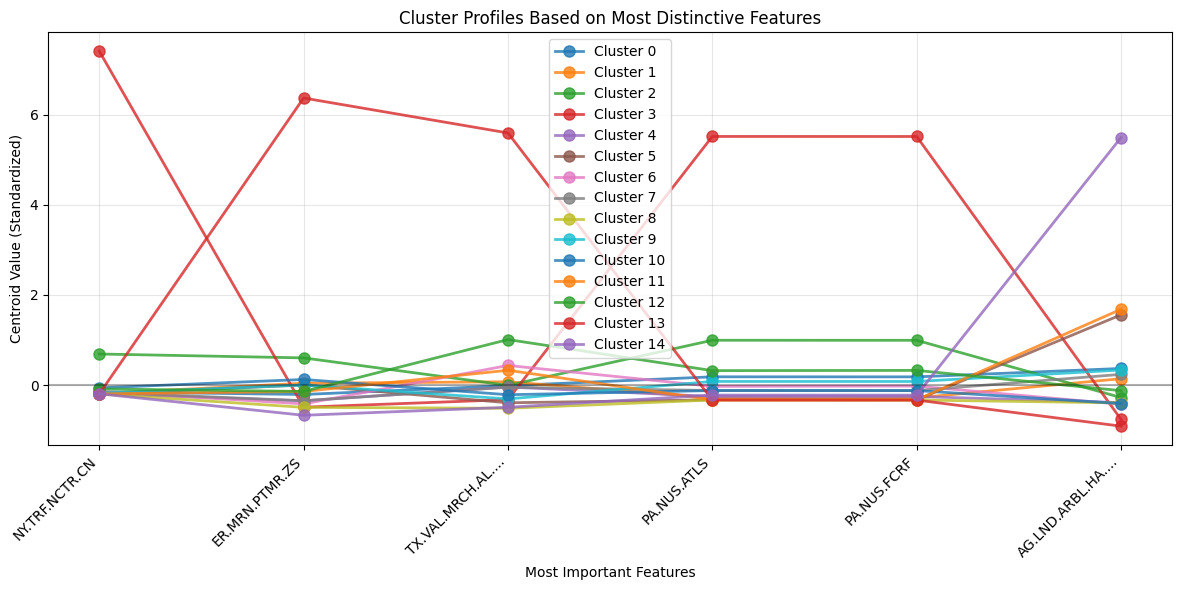

In [16]:
# Visualizing analysis with a comparison plot: 
plt.figure(figsize=(12, 6))

all_feature_importance = []
for cluster_id, centroid in enumerate(centroids):
    for feat_idx, value in enumerate(centroid):
        importance = abs(value)
        all_feature_importance.append((importance, feat_idx, cluster_id))

all_feature_importance.sort(reverse=True)
top_feature_indices = list(dict.fromkeys([feat_idx for _, feat_idx, _ in all_feature_importance]))[:6]  # Top 6 features

for cluster_id, centroid in enumerate(centroids):
    values = [centroid[idx] for idx in top_feature_indices]
    feature_names_short = [feature_names[idx][:15] + '...' if len(feature_names[idx]) > 15 else feature_names[idx] 
                          for idx in top_feature_indices]
    
    plt.plot(range(len(values)), values, 'o-', label=f'Cluster {cluster_id}', 
             linewidth=2, markersize=8, alpha=0.8)

plt.xlabel('Most Important Features')
plt.ylabel('Centroid Value (Standardized)')
plt.title('Cluster Profiles Based on Most Distinctive Features')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(range(len(top_feature_indices)), feature_names_short, rotation=45, ha='right')
plt.axhline(0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

## Part 7.1: Outlier Analysis



OUTLIER ANALYSIS
Number of potential outliers (Z-score > 3): 467
Percentage of data: 99.6%
Number of outliers (Isolation Forest): 24
Percentage of data: 5.1%

Original data shape: (469, 1458)
Clean data shape (outliers removed): (445, 1458)

Re-running k-means on data without outliers...

COMPARISON: WITH vs WITHOUT OUTLIERS
Metric                    With Outliers   Without Outliers Change    
-----------------------------------------------------------------
Total countries           469             445             -24       
Inertia                   13836.5         14188.3         351.8     

Cluster size distribution:
                          Original        Clean          
Cluster 0: 10              83              +73       
Cluster 1: 88              239             +151      
Cluster 2: 43              123             +80       


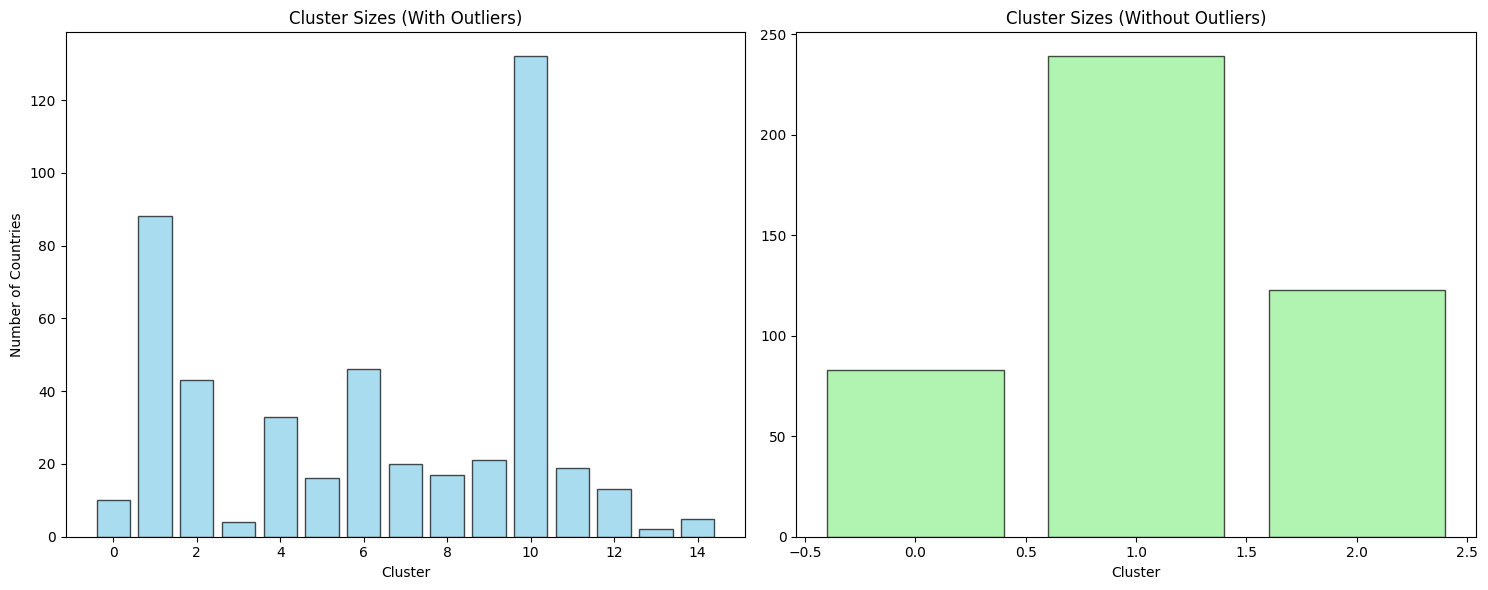


Key insights from outlier removal:
• Outliers typically: Very small rich countries, conflict zones, data anomalies
• Removal often: Reduces inertia, stabilizes clusters, improves interpretation
• Effect: Usually makes clusters more homogeneous and patterns clearer


In [17]:
# OUTLIER ANALYSIS

print("\n" + "="*80)
print("OUTLIER ANALYSIS")
print("="*80)

# Method 1: Z-score based outlier detection
from scipy import stats
z_scores = np.abs(stats.zscore(X))
outlier_mask = (z_scores > 3).any(axis=1)  # Points with any feature > 3 std dev

print(f"Number of potential outliers (Z-score > 3): {outlier_mask.sum()}")
print(f"Percentage of data: {outlier_mask.sum()/len(X)*100:.1f}%")

# Method 2: Isolation Forest (more robust)
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(X)
outlier_mask_iso = outlier_labels == -1

print(f"Number of outliers (Isolation Forest): {outlier_mask_iso.sum()}")
print(f"Percentage of data: {outlier_mask_iso.sum()/len(X)*100:.1f}%")

# Remove outliers and re-cluster
X_clean = X[~outlier_mask_iso]

print(f"\nOriginal data shape: {X.shape}")
print(f"Clean data shape (outliers removed): {X_clean.shape}")

# Re-run k-means on clean data
print("\nRe-running k-means on data without outliers...")
k_clean = k_optimal  # Use same k for comparison

# Use your existing kmeans function
clusters_clean, centroids_clean, count_clean, inertia_clean, shift_clean = kmeans(
    X_clean, k_clean, k_means_plus_plus(X_clean, k_clean), 
    max_it=300, c_change_min=0.0001, inertia_change_min=0.1, stop='centroid'
)

# Compare results
print("\n" + "="*80)
print("COMPARISON: WITH vs WITHOUT OUTLIERS")
print("="*80)

print(f"{'Metric':<25} {'With Outliers':<15} {'Without Outliers':<15} {'Change':<10}")
print("-" * 65)
print(f"{'Total countries':<25} {len(X):<15} {len(X_clean):<15} {len(X_clean)-len(X):<10}")
print(f"{'Inertia':<25} {inertia_history[-1]:<15.1f} {inertia_clean[-1]:<15.1f} {inertia_clean[-1]-inertia_history[-1]:<10.1f}")

# Compare cluster sizes
print(f"\nCluster size distribution:")
print(f"{'':<25} {'Original':<15} {'Clean':<15}")
for i in range(k_clean):
    orig_size = len(clusters[i])
    clean_size = len(clusters_clean[i]) if i < len(clusters_clean) else 0
    print(f"Cluster {i}:{''*(25-len(f'Cluster {i}'))} {orig_size:<15} {clean_size:<15} {clean_size-orig_size:<+10}")

# Visual comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original clusters
sizes_orig = [len(c) for c in clusters]
ax1.bar(range(len(sizes_orig)), sizes_orig, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Cluster Sizes (With Outliers)')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Number of Countries')

# Clean clusters  
sizes_clean = [len(c) for c in clusters_clean]
ax2.bar(range(len(sizes_clean)), sizes_clean, alpha=0.7, color='lightgreen', edgecolor='black')
ax2.set_title('Cluster Sizes (Without Outliers)')
ax2.set_xlabel('Cluster')

plt.tight_layout()
plt.show()

print("\nKey insights from outlier removal:")
print("• Outliers typically: Very small rich countries, conflict zones, data anomalies")
print("• Removal often: Reduces inertia, stabilizes clusters, improves interpretation")
print("• Effect: Usually makes clusters more homogeneous and patterns clearer")

## Part 7.2: Alternative clustering algorithm (DBSCAN)



DBSCAN ALGORITHM COMPARISON


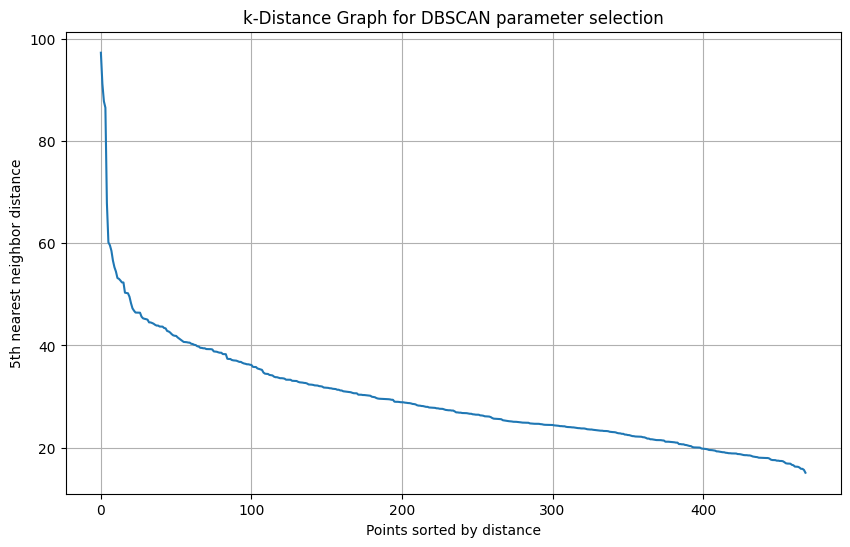

DBSCAN {'eps': 0.5, 'min_samples': 5}: 0 clusters, 469 noise points, silhouette: -1.000
DBSCAN {'eps': 1.0, 'min_samples': 5}: 0 clusters, 469 noise points, silhouette: -1.000
DBSCAN {'eps': 1.5, 'min_samples': 5}: 0 clusters, 469 noise points, silhouette: -1.000
DBSCAN {'eps': 2.0, 'min_samples': 5}: 0 clusters, 469 noise points, silhouette: -1.000

K-MEANS vs DBSCAN COMPARISON
Metric               K-Means         DBSCAN (best)  
--------------------------------------------------
Number of clusters   3               0              
Noise points         0               469            
Silhouette score     0.167           -1.000         


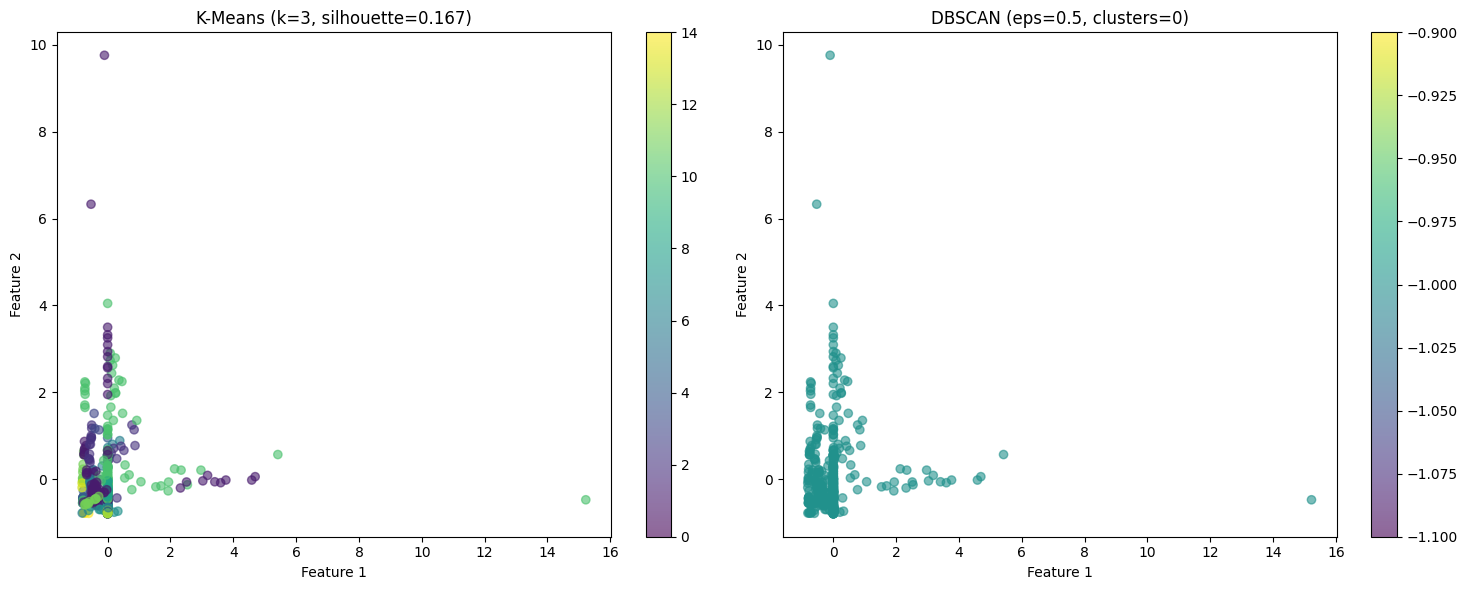

In [18]:
# DBSCAN

print("\n" + "="*80)
print("DBSCAN ALGORITHM COMPARISON")
print("="*80)

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Scale data for DBSCAN (distance-based)
X_scaled = StandardScaler().fit_transform(X)

# Find good DBSCAN parameters using k-distance graph
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=5)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)
k_distances = np.sort(distances[:, -1])[::-1]

plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('5th nearest neighbor distance')
plt.title('k-Distance Graph for DBSCAN parameter selection')
plt.grid(True)
plt.show()

# Try DBSCAN with different parameters (FIXED - no random_state)
dbscan_params = [
    {'eps': 0.5, 'min_samples': 5},
    {'eps': 1.0, 'min_samples': 5}, 
    {'eps': 1.5, 'min_samples': 5},
    {'eps': 2.0, 'min_samples': 5}
]

dbscan_results = []
for params in dbscan_params:
    dbscan = DBSCAN(**params)  # REMOVED random_state
    labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    # Silhouette score (excluding noise)
    if n_clusters > 1:
        valid_mask = labels != -1
        if valid_mask.sum() > 0:  # Ensure we have points to score
            silhouette = silhouette_score(X_scaled[valid_mask], labels[valid_mask])
        else:
            silhouette = -1
    else:
        silhouette = -1
    
    dbscan_results.append({
        'params': params,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette': silhouette,
        'labels': labels
    })
    
    print(f"DBSCAN {params}: {n_clusters} clusters, {n_noise} noise points, silhouette: {silhouette:.3f}")

# Compare with k-means
best_dbscan = max(dbscan_results, key=lambda x: x['silhouette'] if x['silhouette'] != -1 else -10)

print("\n" + "="*80)
print("K-MEANS vs DBSCAN COMPARISON")
print("="*80)

print(f"{'Metric':<20} {'K-Means':<15} {'DBSCAN (best)':<15}")
print("-" * 50)
print(f"{'Number of clusters':<20} {k_optimal:<15} {best_dbscan['n_clusters']:<15}")
print(f"{'Noise points':<20} {'0':<15} {best_dbscan['n_noise']:<15}")
print(f"{'Silhouette score':<20} {silhouette_scores[k_optimal-2]:<15.3f} {best_dbscan['silhouette']:<15.3f}")

# Visual comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# K-means results (using your existing cluster labels)
kmeans_labels = np.zeros(len(X))
for i, cluster in enumerate(clusters):
    for point in cluster:
        idx = np.where((X == point).all(axis=1))[0]
        if len(idx) > 0:
            kmeans_labels[idx[0]] = i

# Plot k-means
scatter1 = ax1.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
ax1.set_title(f'K-Means (k={k_optimal}, silhouette={silhouette_scores[k_optimal-2]:.3f})')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
plt.colorbar(scatter1, ax=ax1)

# Plot DBSCAN
scatter2 = ax2.scatter(X[:, 0], X[:, 1], c=best_dbscan['labels'], cmap='viridis', alpha=0.6)
ax2.set_title(f'DBSCAN (eps={best_dbscan["params"]["eps"]}, clusters={best_dbscan["n_clusters"]})')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()
